# 0. Import packages

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel
from transformers import AutoModelForCausalLM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

# 1. GPT2 Introduction
### GPT-2 is an autoregressive language model based on Transformer Decoder.

It learns to maximize the likelihood of a text sequence:

P(x₁, x₂, …, xₙ) = ∏ᵢ P(xᵢ | x₁, …, xᵢ₋₁)

This means the model predicts each token given all the previous tokens.
- pretrained model
- decoding strategies
    - iteratively
    - quelity & diversity

# 2. GPT2 Model

In [5]:
model_name = 'gpt2' # parameters: gpt2 < gpt2-medium < gpt2-large < gpt2-xl

config = AutoConfig.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## 2.1 Parameters Statistcs

In [7]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("gpt2")

print(model.num_parameters())

124439808


## 2.2 GPT2 model constructure

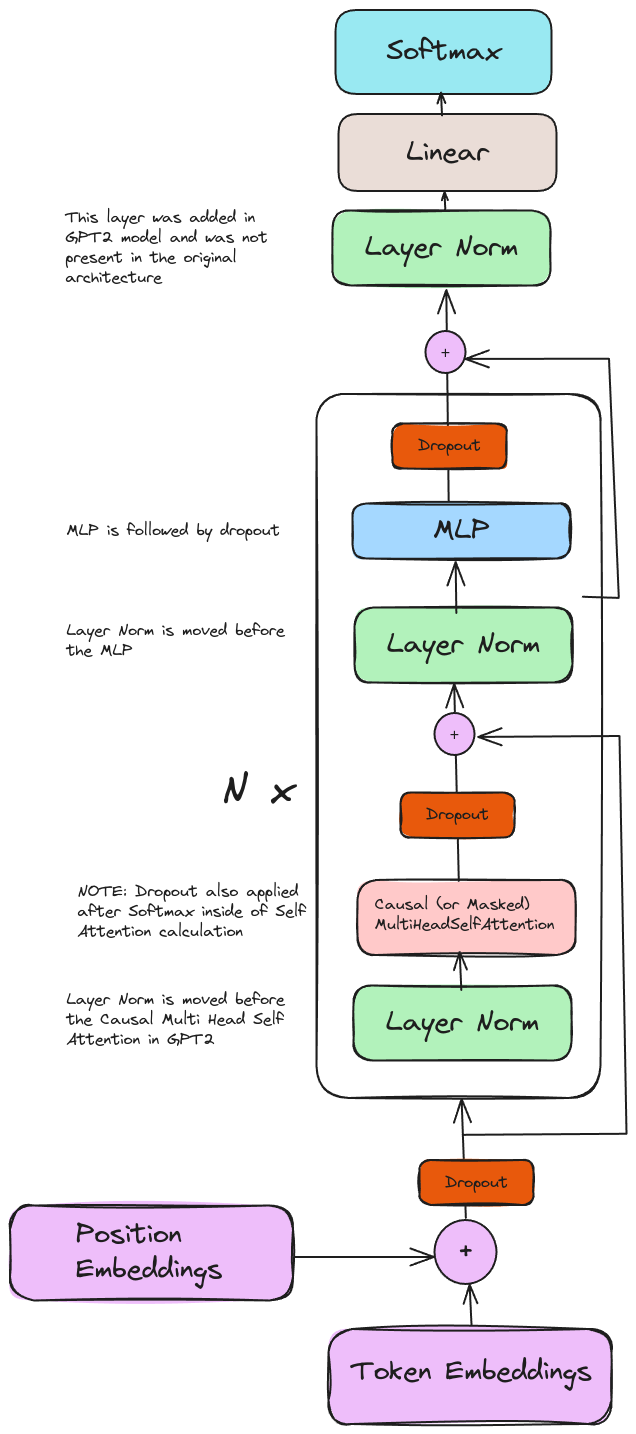

In [60]:
from IPython.display import Image
Image(filename='Images/gpt2.png', width=400)

In [10]:
config, model

(GPT2Config {
   "activation_function": "gelu_new",
   "architectures": [
     "GPT2LMHeadModel"
   ],
   "attn_pdrop": 0.1,
   "bos_token_id": 50256,
   "embd_pdrop": 0.1,
   "eos_token_id": 50256,
   "initializer_range": 0.02,
   "layer_norm_epsilon": 1e-05,
   "model_type": "gpt2",
   "n_ctx": 1024,
   "n_embd": 768,
   "n_head": 12,
   "n_inner": null,
   "n_layer": 12,
   "n_positions": 1024,
   "reorder_and_upcast_attn": false,
   "resid_pdrop": 0.1,
   "scale_attn_by_inverse_layer_idx": false,
   "scale_attn_weights": true,
   "summary_activation": null,
   "summary_first_dropout": 0.1,
   "summary_proj_to_labels": true,
   "summary_type": "cls_index",
   "summary_use_proj": true,
   "task_specific_params": {
     "text-generation": {
       "do_sample": true,
       "max_length": 50
     }
   },
   "transformers_version": "4.55.4",
   "use_cache": true,
   "vocab_size": 50257
 },
 GPT2LMHeadModel(
   (transformer): GPT2Model(
     (wte): Embedding(50257, 768)
     (wpe): Embedd

## 2.3 tokenizer

In [13]:
tokenizer

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

In [15]:
tokenizer('My favorite color is chartreuse')

{'input_ids': [3666, 4004, 3124, 318, 8262, 260, 1904], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [18]:
tokenizer.encode('chartreuse')

[40926, 260, 1904]

## 2.4 attention_mask

In [19]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')

context = tokenizer("It will rain in the", return_tensors='pt')
context

{'input_ids': tensor([[1026,  481, 6290,  287,  262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [23]:
# tokenizer.padding_side = 'left'
tokenizer.padding_side = 'right'

tokenizer.pad_token = tokenizer.eos_token

sentences = ["What is ur name",
            "My name is reven",
            "you can also can me tannn"]

inputs = tokenizer(sentences, return_tensors='pt', padding=True)
inputs.input_ids, inputs.attention_mask

(tensor([[ 2061,   318,  2956,  1438, 50256, 50256, 50256, 50256],
         [ 3666,  1438,   318,  8934, 50256, 50256, 50256, 50256],
         [ 5832,   460,   635,   460,   502,   256,  1236,    77]]),
 tensor([[1, 1, 1, 1, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1]]))

# 3.forward
- GPT2Model
    - wte: word token embedding
    - wpe: word position embedding
- LMHead
    - mlp: hidden_state -> vocab_size
 
**AutoModelForCausalLM** -> Returns a model specifically for use with Causal Language Modeling (CLM).

In [28]:
model_name = 'gpt2'
model = AutoModel.from_pretrained(model_name)
model_clm = AutoModelForCausalLM.from_pretrained(model_name).to(device)

input_txt = "Long long ago, a beautiful girl Change"
model_inputs = tokenizer(input_txt, return_tensors='pt')
model_inputs

{'input_ids': tensor([[14617,   890,  2084,    11,   257,  4950,  2576,  9794]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [38]:
input_ids = model_inputs['input_ids'].to(device)
output = model_clm(input_ids=input_ids)
output.keys(), output.logits.shape # [batch_size, seq_len, vocab_size]

(odict_keys(['logits', 'past_key_values']), torch.Size([1, 8, 50257]))

## 3.1 model.transformer()
### The dimension change of Masked Multihead Attention:
- hidden_states: [B, T, H]
    - Q = hidden_states @ Wq → [B, T, H]
    - K = hidden_states @ Wk → [B, T, H]
    - V = hidden_states @ Wv → [B, T, H]
- Head separation (num_heads = h, head_dim = H/h)
    - Q, K, V → [B, h, T, head_dim]
- Attention scores (logits)
    - scores = (Q @ K^T) / sqrt(head_dim)  # [B, h, T, T]
- Add mask to scores:
    - causal_mask: [1, 1, T, T] → broadcast to [B, h, T, T]
    - padding_mask: Expands from input [B, T] to [B, 1, 1, T] (masking the K/key dimension), then broadcasts to [B, h, T, T]
    - Merge: scores = scores + causal_mask + padding_mask_expanded
- Normalization, Pooling
    - weights = softmax(scores, dim=-1)      # [B, h, T, T]
    - context = weights @ V                  # [B, h, T, head_dim]
    - context → concat heads → [B, T, H]  # [B, T, H]

In [41]:
model_clm.eval()
model_clm.transformer(input_ids).last_hidden_state, model_clm.transformer(input_ids).last_hidden_state.shape # [batch_size, seq_len, hidden_size]

(tensor([[[-0.0586, -0.0932, -0.3173,  ..., -0.1435, -0.1369, -0.2333],
          [ 0.4658,  0.4379, -1.2102,  ...,  0.3628, -0.2413, -0.7169],
          [ 0.0395,  0.1790, -0.6736,  ...,  0.1583, -0.2071, -0.8343],
          ...,
          [ 0.0228,  0.2336, -0.8696,  ...,  0.4340, -0.1474, -0.1052],
          [-0.2355,  0.1719, -0.6657,  ...,  0.3529, -0.0726, -0.4060],
          [-0.3583,  0.2884,  0.5370,  ...,  0.0587,  0.1511, -0.6166]]],
        device='mps:0', grad_fn=<ViewBackward0>),
 torch.Size([1, 8, 768]))

## 3.2 Custom model.transformer()

In [47]:
model_clm

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [70]:
def gpt2_transformer_forward(model, input_ids):
    """
    A minimal, readable forward pass that mirrors GPT-2's core steps.

    Args:
        model: A GPT-2 style model from Hugging Face.
        input_ids: shape -> [batch, seq_len].

    Returns:
        hidden_states: FloatTensor [batch, seq_len, hidden] — final layer representations.
    """
    model.eval()

    # input_ids: [B, T]
    B, T = input_ids.shape

    # position_ids: [B, T] = [[0,1,2,...,T-1], ...] for each batch row
    position_ids = torch.arange(0, T, device=device).unsqueeze(0).expand(B, T)

    # Embeddings: token + position
    # wte: token embedding
    # wpe: position embedding
    inputs_embeds   = model.wte(input_ids)        # [B, T, H]
    position_embeds = model.wpe(position_ids)     # [B, T, H]
    hidden_states   = model.drop(inputs_embeds + position_embeds)

    # Head mask (none => keep all heads)
    head_mask = model.get_head_mask(None, model.config.n_layer)

    # Causal self-attention blocks
    past_key_values = (None,) * len(model.h)
    for i, (block, layer_past) in enumerate(zip(model.h, past_key_values)):
        # HF blocks accept attention_mask as an additive mask (broadcast inside)
        outputs = block(
            hidden_states,
            layer_past=layer_past,
            head_mask=head_mask[i],
        )
        hidden_states = outputs[0]  # [B, T, H]

    # Final layer norm
    hidden_states = model.ln_f(hidden_states)     # [B, T, H]

    return hidden_states

In [71]:
with torch.no_grad():
    print(gpt2_transformer_forward(model_clm.transformer, input_ids))

<generator object Module.parameters at 0x128014430>
<generator object Module.parameters at 0x128014cf0>
<generator object Module.parameters at 0x128014cf0>
<generator object Module.parameters at 0x128014cf0>
<generator object Module.parameters at 0x128014cf0>
<generator object Module.parameters at 0x128014cf0>
<generator object Module.parameters at 0x128014cf0>
<generator object Module.parameters at 0x128014cf0>
<generator object Module.parameters at 0x128014cf0>
<generator object Module.parameters at 0x128014cf0>
<generator object Module.parameters at 0x128014cf0>
<generator object Module.parameters at 0x128014cf0>
tensor([[[-0.0586, -0.0932, -0.3173,  ..., -0.1435, -0.1369, -0.2333],
         [ 0.4658,  0.4379, -1.2102,  ...,  0.3628, -0.2413, -0.7169],
         [ 0.0395,  0.1790, -0.6736,  ...,  0.1583, -0.2071, -0.8343],
         ...,
         [ 0.0228,  0.2336, -0.8696,  ...,  0.4340, -0.1474, -0.1052],
         [-0.2355,  0.1719, -0.6657,  ...,  0.3529, -0.0726, -0.4060],
       

## 3.3 Imhead_model(input_ids)

In [42]:
model_clm(input_ids=input_ids).logits

tensor([[[ -30.1373,  -29.4010,  -32.8656,  ...,  -37.5889,  -36.4895,
           -30.3170],
         [ -51.1490,  -51.4944,  -58.3481,  ...,  -57.6115,  -55.9324,
           -53.2525],
         [ -54.9341,  -55.7322,  -63.4353,  ...,  -63.0942,  -61.5596,
           -58.4904],
         ...,
         [ -96.5268,  -93.9759, -102.5888,  ..., -102.7486,  -99.4243,
           -98.5395],
         [-113.7941, -113.4282, -122.1399,  ..., -123.7997, -112.4486,
          -116.4553],
         [ -84.3838,  -86.4685,  -89.9249,  ...,  -94.6217,  -88.0979,
           -88.8760]]], device='mps:0', grad_fn=<LinearBackward0>)

## 3.4 Custom Imhead_model forward

In [44]:
def gpt2_clm_forward(model, input_ids):
    model.eval()
    transformer_outputs = model.transformer(input_ids)
    hidden_states = transformer_outputs[0]
    lm_logits = model.lm_head(hidden_states)
    return lm_logits

In [45]:
gpt2_clm_forward(model_clm, input_ids)

tensor([[[ -30.1373,  -29.4010,  -32.8656,  ...,  -37.5889,  -36.4895,
           -30.3170],
         [ -51.1490,  -51.4944,  -58.3481,  ...,  -57.6115,  -55.9324,
           -53.2525],
         [ -54.9341,  -55.7322,  -63.4353,  ...,  -63.0942,  -61.5596,
           -58.4904],
         ...,
         [ -96.5268,  -93.9759, -102.5888,  ..., -102.7486,  -99.4243,
           -98.5395],
         [-113.7941, -113.4282, -122.1399,  ..., -123.7997, -112.4486,
          -116.4553],
         [ -84.3838,  -86.4685,  -89.9249,  ...,  -94.6217,  -88.0979,
           -88.8760]]], device='mps:0', grad_fn=<LinearBackward0>)